# Morphology Graph Construction - Barcelona Case Study

This notebook generates a visualization of the morphological graph construction process for the City2Graph documentation (Section 3.1.1).

In [ ]:
import warnings
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Polygon, box, Point
import city2graph

warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "sans-serif"

In [ ]:
# 1. Define Area and Load Data
target_crs = "EPSG:25831" # ETRS89 / UTM zone 31N

# Define area by center and radius (meters)
center = [2.1625, 41.3925] # [lon, lat] (Barcelona Eixample)
dist = 1000 # meters from center

# Calculate bbox
center_geom = gpd.GeoSeries([Point(center)], crs="EPSG:4326").to_crs(target_crs).iloc[0]
minx, miny, maxx, maxy = center_geom.x - dist, center_geom.y - dist, center_geom.x + dist, center_geom.y + dist
bbox_poly = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({"geometry": [bbox_poly]}, crs=target_crs).to_crs("EPSG:4326")
bbox = bbox_gdf.total_bounds

# Download/Load Data
print("Loading data...")
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

# Check if files exist, if not download
if not os.path.exists(os.path.join(data_dir, "barcelona_building.geojson")):
    print("Downloading data from Overture Maps...")
    bbox_gdf = gpd.GeoDataFrame({"geometry": [box(*bbox)]}, crs="EPSG:4326")
    bbox_buffered_geom = bbox_gdf.to_crs(target_crs).buffer(700).to_crs("EPSG:4326").iloc[0]

    city2graph.load_overture_data(
        area=bbox_buffered_geom,
        types=["building", "segment", "connector"],
        output_dir=data_dir,
        prefix="barcelona_",
        save_to_file=True,
    )

# Read Data
buildings_gdf = gpd.read_file(os.path.join(data_dir, "barcelona_building.geojson")).to_crs(target_crs)
segments_gdf = gpd.read_file(os.path.join(data_dir, "barcelona_segment.geojson")).to_crs(target_crs)
connectors_gdf = gpd.read_file(os.path.join(data_dir, "barcelona_connector.geojson")).to_crs(target_crs)

print(f"Loaded {len(buildings_gdf)} buildings, {len(segments_gdf)} segments.")

In [ ]:
# Filter
segments_filtered = segments_gdf[segments_gdf.geometry.type != "MultiLineString"]
segments_filtered = segments_filtered[segments_filtered["subtype"] == "road"]

# Process Segments (create barriers)
print("Processing segments...")
segments_processed = city2graph.process_overture_segments(
    segments_gdf=segments_filtered,
    get_barriers=True,
    connectors_gdf=connectors_gdf,
)

# Build Morphological Graph
print("Building morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_processed,
    keep_buildings=True,
)

print("Graph built.")

In [ ]:
# 1. Define Area and Load Data
target_crs = "EPSG:25831" # ETRS89 / UTM zone 31N

# Define area by center and radius (meters)
center = [2.1625, 41.3925] # [lon, lat] (Barcelona Eixample)
dist = 1000 # meters from center

# Calculate bbox
center_geom = gpd.GeoSeries([Point(center)], crs="EPSG:4326").to_crs(target_crs).iloc[0]
minx, miny, maxx, maxy = center_geom.x - dist, center_geom.y - dist, center_geom.x + dist, center_geom.y + dist
bbox_poly = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({"geometry": [bbox_poly]}, crs=target_crs).to_crs("EPSG:4326")
bbox = bbox_gdf.total_bounds


In [ ]:
bbox_gdf = bbox_gdf.to_crs(target_crs)
bbox_poly = box(*bbox_gdf.total_bounds)

In [ ]:
# 3. Focus Area Clipping
# Clip to a smaller area for clearer visualization

print("Clipping graph... ")

# Explicitly clip tessellation geometry
tessellation_gdf = morpho_nodes["private"][["enclosure_index", "tessellation_geometry"]].copy()
tessellation_gdf = tessellation_gdf.set_geometry("tessellation_geometry")
if tessellation_gdf.crs is None:
    tessellation_gdf.set_crs(morpho_nodes["private"].crs, inplace=True)
morpho_tessellation_clipped = gpd.clip(tessellation_gdf, bbox_gdf)

morpho_nodes_clipped = {
    "private": gpd.clip(morpho_nodes["private"], bbox_gdf),
    "public": gpd.clip(morpho_nodes["public"], bbox_gdf),
}

morpho_edges_clipped = {
    ("private", "touched_to", "private"): gpd.clip(morpho_edges[("private", "touched_to", "private")], bbox_gdf),
    ("public", "connected_to", "public"): gpd.clip(morpho_edges[("public", "connected_to", "public")], bbox_gdf),
    ("private", "faced_to", "public"): gpd.clip(morpho_edges[("private", "faced_to", "public")], bbox_gdf),
}

private_centroids = morpho_nodes_clipped["private"].centroid
public_midpoints = morpho_nodes_clipped["public"].centroid
xlim = [bbox_poly.bounds[0], bbox_poly.bounds[2]]
ylim = [bbox_poly.bounds[1], bbox_poly.bounds[3]]

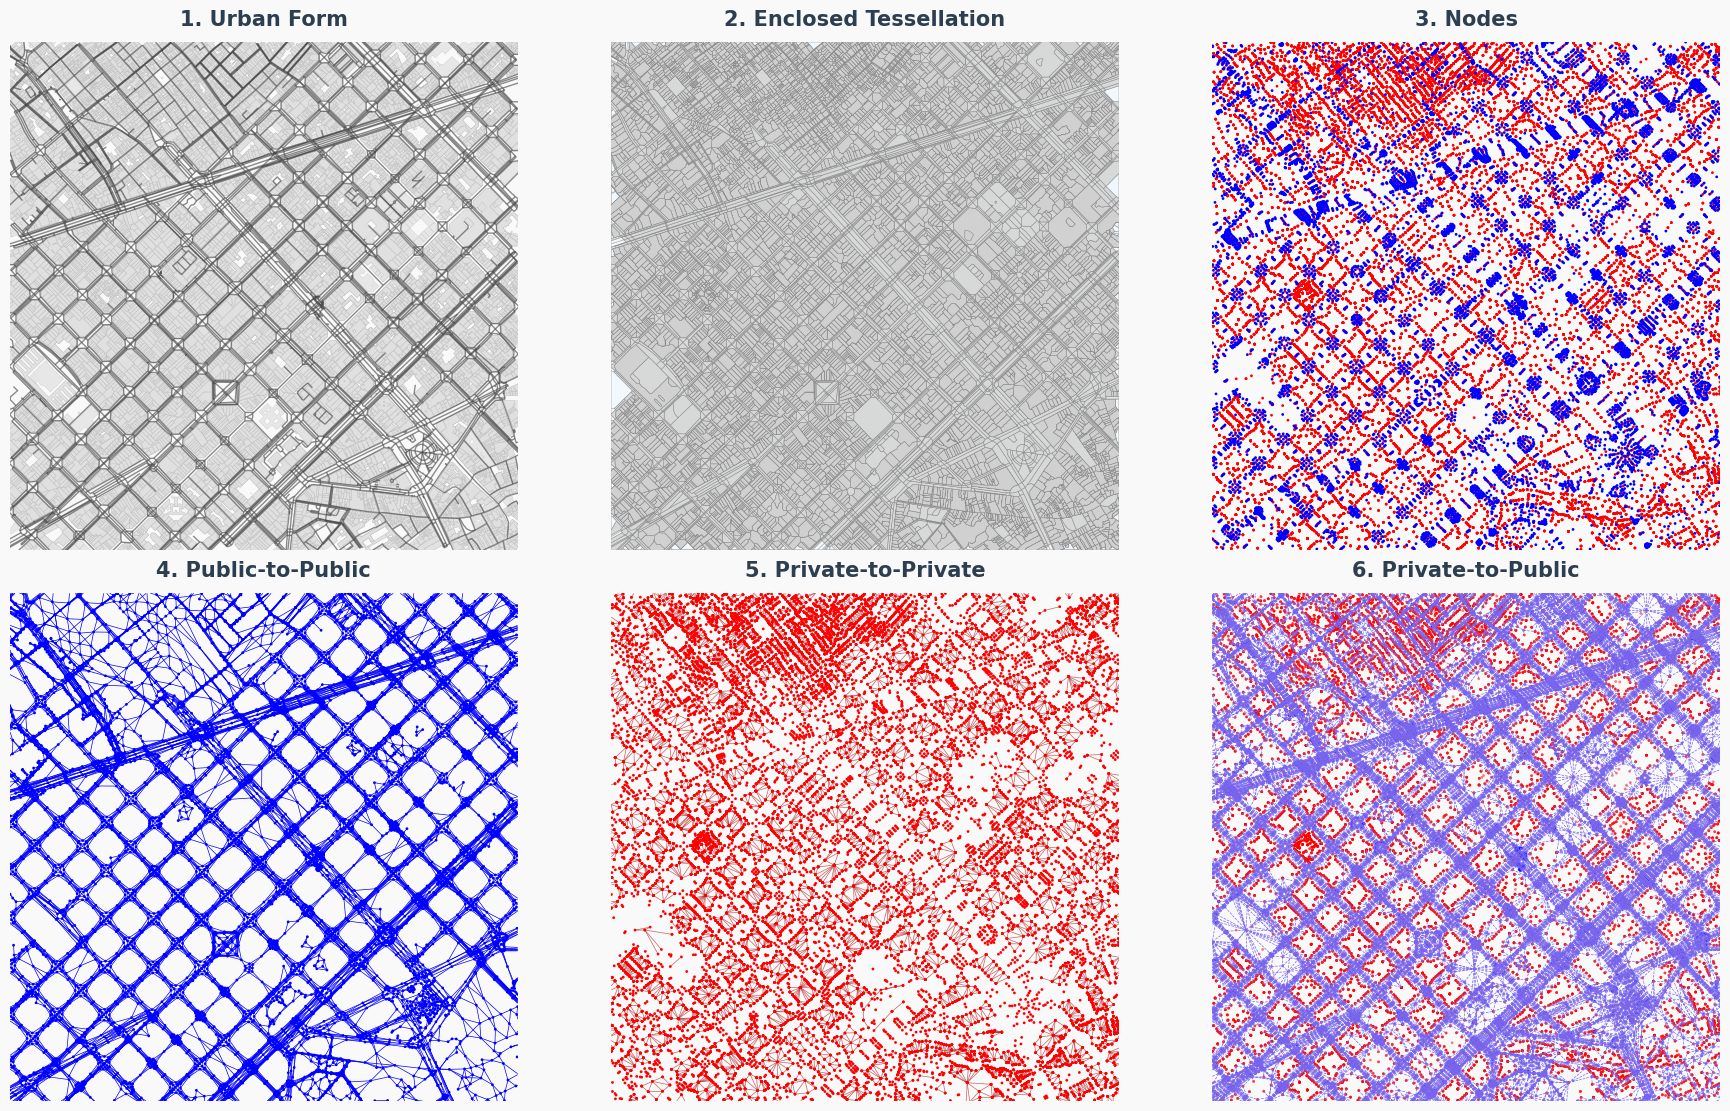

In [17]:
# Restore Light Theme
plt.rcParams.update({
    "figure.facecolor": "#f9f9f9",
    "axes.facecolor": "#f9f9f9",
    "savefig.facecolor": "#f9f9f9"
})

# Common Settings
node_s = 4
private_color, public_color = "red", "blue"
private_edge_color, public_edge_color, interface_edge_color = "#B22222", "#0000FF", "#7B68EE"

# Figure 2: Steps (2x3 Layout)
fig, axes = plt.subplots(2, 3, figsize=(18, 11), constrained_layout=True)
axes = axes.flatten()
titles = [
    "1. Urban Form", "2. Enclosed Tessellation", "3. Nodes",
    "4. Public-to-Public", "5. Private-to-Private", "6. Private-to-Public"
]

for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=15, color='#2c3e50', pad=12, weight='bold')
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# 1. Urban Form
morpho_nodes_clipped["private"]["building_geometry"].plot(ax=axes[0], color="#e0e0e0", edgecolor="#c0c0c0", linewidth=0.3, alpha=0.7, zorder=2)
morpho_nodes_clipped["public"]["segment_geometry"].plot(ax=axes[0], color="#404040", linewidth=1, alpha=0.6, zorder=3)

# 2. Tessellation
#morpho_nodes_clipped["public"]["segment_geometry"].plot(ax=axes[1], color="#e0e0e0", linewidth=0.5, alpha=0.5, zorder=1)
morpho_tessellation_clipped.plot(ax=axes[1], color="#f0f8ff", edgecolor="#a0a0a0", linewidth=0.5, alpha=0.6, zorder=2)
morpho_nodes_clipped["private"]["tessellation_geometry"].plot(ax=axes[1], color="#d0d0d0", edgecolor="#808080", linewidth=0.3, alpha=0.8, zorder=3)

# 3. Nodes
axes[2].scatter(private_centroids.x, private_centroids.y, color=private_color, s=node_s, edgecolors="none", zorder=10)
axes[2].scatter(public_midpoints.x, public_midpoints.y, color=public_color, s=node_s, edgecolors="none", zorder=10)

# 4. Public-to-Public
axes[3].scatter(public_midpoints.x, public_midpoints.y, color=public_color, s=node_s, alpha=1, edgecolors="none", zorder=10)
morpho_edges_clipped[("public", "connected_to", "public")].plot(ax=axes[3], color=public_edge_color, linewidth=0.5, alpha=1, zorder=5)

# 5. Private-to-Private
axes[4].scatter(private_centroids.x, private_centroids.y, color=private_color, s=node_s, alpha=1, edgecolors="none", zorder=10)
morpho_edges_clipped[("private", "touched_to", "private")].plot(ax=axes[4], color=private_edge_color, linewidth=0.5, alpha=0.7, zorder=4)

# 6. Private-to-Public
axes[5].scatter(private_centroids.x, private_centroids.y, color=private_color, s=node_s, alpha=0.5, edgecolors="none")
axes[5].scatter(public_midpoints.x, public_midpoints.y, color=public_color, s=node_s, alpha=0.5, edgecolors="none")
morpho_edges_clipped[("private", "faced_to", "public")].plot(ax=axes[5], color=interface_edge_color, linewidth=0.5, alpha=1, linestyle="--", zorder=6)

# Save Figure
plt.savefig("morphology_steps.png", dpi=300, bbox_inches="tight")


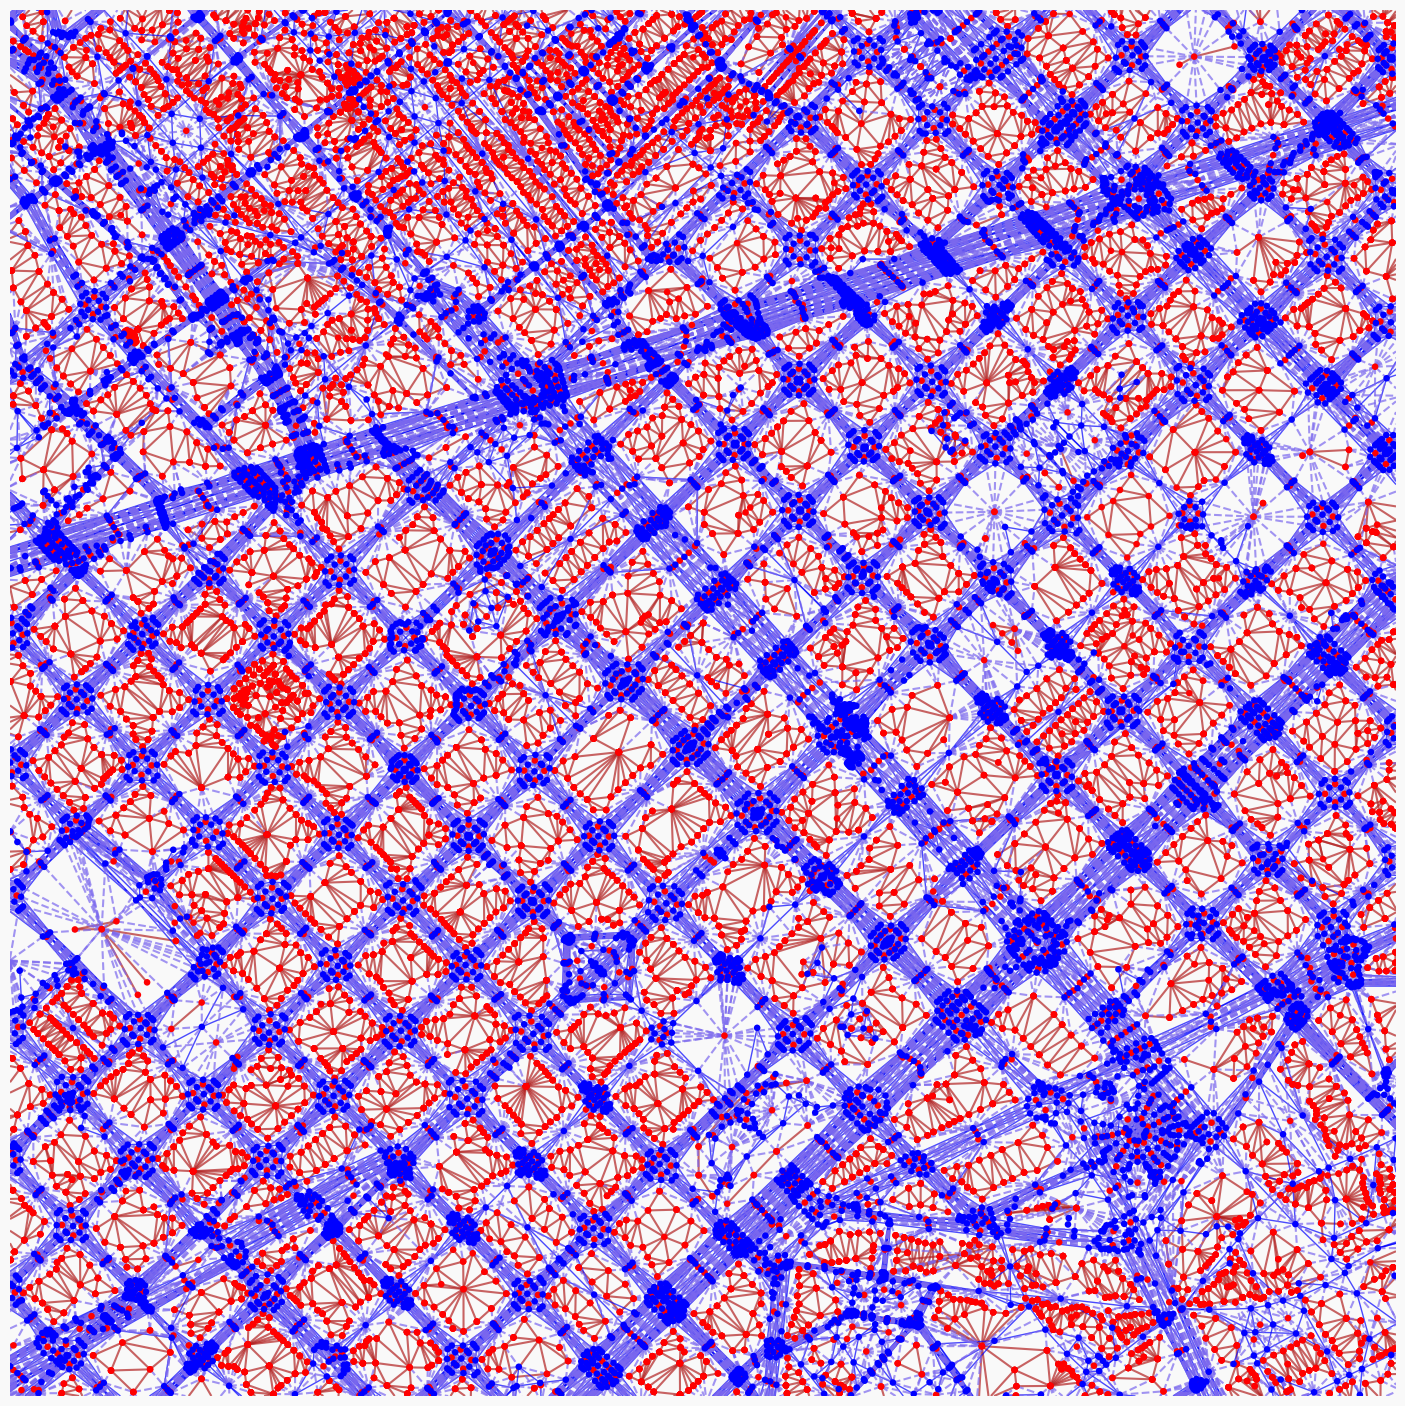

In [18]:
# Restore Light Theme
plt.rcParams.update({
    "figure.facecolor": "#f9f9f9",
    "axes.facecolor": "#f9f9f9",
    "savefig.facecolor": "#f9f9f9"
})

# Common Settings
node_s = 15
private_color, public_color = "red", "blue"
private_edge_color, public_edge_color, interface_edge_color = "#B22222", "#0000FF", "#7B68EE"

# Figure 1: Main Graph (Default Layout)
fig, ax = plt.subplots(figsize=(18, 18)) # Square default
ax.set_aspect('equal')
ax.axis('off')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Edges
morpho_edges_clipped[("private", "touched_to", "private")].plot(ax=ax, color=private_edge_color, linewidth=1.5, alpha=0.7, zorder=4)
morpho_edges_clipped[("public", "connected_to", "public")].plot(ax=ax, color=public_edge_color, linewidth=1.0, alpha=0.7, zorder=5)
morpho_edges_clipped[("private", "faced_to", "public")].plot(ax=ax, color=interface_edge_color, linewidth=1.5, alpha=0.7, linestyle="--", zorder=6)
# Nodes
ax.scatter(private_centroids.x, private_centroids.y, color=private_color, s=node_s*1.5, edgecolors="none", zorder=10)
ax.scatter(public_midpoints.x, public_midpoints.y, color=public_color, s=node_s*1.5, edgecolors="none", zorder=10)

# Save Figure
plt.savefig("morphology_graph.png", dpi=300, bbox_inches="tight")


In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load images
if os.path.exists("morphology_steps.png") and os.path.exists("morphology_graph.png"):
    # Steps (Right)
    img_right = Image.open("morphology_steps.png")
    # Main Graph (Left)
    img_left = Image.open("morphology_graph.png")
    
    # Adjust height of Left image to match Right image
    # Calculate new width for Left maintaining aspect ratio
    aspect_ratio_left = img_left.width / img_left.height
    new_height = img_right.height
    new_width_left = int(new_height * aspect_ratio_left)
    
    img_left_resized = img_left.resize((new_width_left, new_height), Image.Resampling.LANCZOS)
    
    # Combine Horizontally
    total_width = img_left_resized.width + img_right.width
    max_height = max(img_left_resized.height, img_right.height)
    
    combined_img = Image.new("RGB", (total_width, max_height), (255, 255, 255))
    combined_img.paste(img_left_resized, (0, 0))
    combined_img.paste(img_right, (img_left_resized.width, 0))
    
    combined_img.save("morphology_combined.png")
    print("Combined image saved as morphology_combined.png")
else:
    print("Images not found. Please run the plotting cells first.")


Combined image saved as morphology_combined.png
